In [2]:
###########################################
# This file contains the following:
# 1. Linear Transformer Model (modified for simpler gating)
# 2. Function for clipping gradient
# 3. Function for generating random data
###########################################

import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def attention(P,Q,Z, activation = None):
    B= Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    P_full =  torch.cat([P,torch.zeros(1,d).to(device)],dim=0)
    P_full =  torch.cat([P_full,torch.zeros(d+1,1).to(device)],dim=1)
    P_full[d,d] = 1
    Q_full = torch.cat([Q, torch.zeros(1,d).to(device)],dim=0)
    Q_full = torch.cat([Q_full, torch.zeros(d+1,1).to(device)],dim=1)
    A = torch.eye(N+1).to(device)
    A[N,N] = 0
    Attn = torch.einsum('BNi, ij, BMj -> BNM', (Z,Q_full,Z))
    if activation is not None:
        Attn = activation(Attn)
    key = torch.einsum('ij, BNj -> BNi', (P_full,Z))
    Output = torch.einsum('BNM,ML, BLi -> BNi', (Attn,A,key))
    return Output /N

class Transformer_F(nn.Module):
    def __init__(self, n_layer, n_head, N, d, var, run_mode, head_choice=None):
        super(Transformer_F, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d)))

        # self.gamma = nn.Parameter(torch.zeros(n_layer, 1, N+1, d+1), requires_grad=(run_mode == 1))

        with torch.no_grad():
            self.allparam.normal_(0, var)

        self.n_layer = n_layer
        self.n_head = n_head
        self.run_mode = run_mode
        self.head_choice = head_choice  # The chosen head index for run_mode=0

        # Simplified gating mechanism:
        # One gating parameter per head for all layers.
        self.gate = nn.Parameter(torch.zeros(n_head), requires_grad=(run_mode == 1))

    def forward(self, Z):
        B, N, d = Z.shape[0], Z.shape[1]-1, Z.shape[2]-1

        # R = [torch.zeros_like(Z) for _ in range(self.n_layer)]

        # self.zero_p()

        # If run_mode=1, precompute the gating weights once
        if self.run_mode == 1:
        # Directly use gate parameters
        # This might mean some heads get negative weights unless you ensure non-negativity
          #gate_weights = F.softmax(self.gate, dim=-1)  # (n_head,)
          gate_weights_expanded = self.gate.view(-1, 1, 1, 1)

        for i in range(self.n_layer):
            Zi = Z

            if self.run_mode == 0:
                # If no head_choice is provided, default to head 0
                chosen_head = self.head_choice if self.head_choice is not None else 0
                Pij = self.allparam[i, chosen_head, 0, :, :]
                Qij = self.allparam[i, chosen_head, 1, :, :]
                attention_sum = attention(Pij, Qij, Zi)

            elif self.run_mode == 1:
                # Compute attention for all heads
                head_attentions = []
                for j in range(self.n_head):
                    Pij = self.allparam[i, j, 0, :, :]
                    Qij = self.allparam[i, j, 1, :, :]
                    head_attentions.append(attention(Pij, Qij, Zi))
                head_attentions = torch.stack(head_attentions, dim=0)  # (n_head, B, N+1, d+1)

                # Apply gating: use same weights for all layers
                attention_sum = (head_attentions * gate_weights_expanded).sum(dim=0)

            else:
                raise ValueError("Invalid run_mode. Should be 0 or 1.")

            # Compute the residual and update Z
            # R[i] = attention_sum
            Z = Zi + attention_sum
        return Z

    def zero_p(self):
      for i in range(self.n_layer):
          for j in range(self.n_head):
              with torch.no_grad():
                  self.allparam[i,j,0,:,:].zero_()

def in_context_loss(model, Z, y):
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    output = model(Z)
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean()
    return loss

def generate_data(mode='normal',
                  N=20,
                  d=1,
                  B=1000,
                  shape_k=0.1,
                  U=None,
                  D=None,
                  data_variance=1.0,
                  data_mean=0.0):  # <-- New argument for non-zero mean
    """
    mode: 'normal', 'sphere', 'gamma', 'relu', or 'mlp'
    N, d, B: as before
    data_variance: variance of the Gaussian
    data_mean: mean of the Gaussian
    """
    std = math.sqrt(data_variance)

    # Notice that now we use data_mean (instead of 0) in normal_:
    W = torch.FloatTensor(B, d).normal_(data_mean, std).to(device)
    X = torch.FloatTensor(B, N, d).normal_(data_mean, std).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(data_mean, std).to(device)

    if U is not None:
        U = U.to(device)
        D = D.to(device)
        # Same transformations as before
        W = torch.mm(W, torch.inverse(D))
        W = torch.mm(W, U.t())

    if mode == 'sphere':
        X.div_(X.norm(p=2, dim=2)[:, :, None])
        X_test.div_(X_test.norm(p=2, dim=2)[:, :, None])
    elif mode == 'gamma':
        gamma_scales = np.random.gamma(shape=shape_k,
                                       scale=(10 / shape_k) ** 0.5,
                                       size=[B, N])
        gamma_scales = torch.Tensor(gamma_scales).to(device).sqrt()
        gamma_test_scales = np.random.gamma(shape=shape_k,
                                            scale=(10 / shape_k) ** 0.5,
                                            size=[B, 1])
        gamma_test_scales = torch.Tensor(gamma_test_scales).to(device).sqrt()

        # Normalize, then scale
        X.div_(X.norm(p=2, dim=2)[:, :, None])
        X_test.div_(X_test.norm(p=2, dim=2)[:, :, None])
        X.mul_(gamma_scales[:, :, None])
        X_test.mul_(gamma_test_scales[:, :, None])

    elif mode == 'normal':
        pass  # (already used data_mean in normal_)
    elif mode == 'relu':
        return generate_data_relu(N=N, d=d, B=B, hidden_dim=d)
    elif mode == 'mlp':
        return generate_data_mlp(N=N, d=d, B=B, hidden_dim=d)
    else:
        raise ValueError(f"Unknown mode: {mode}")

    # If U and D are provided, apply the linear transform:
    if U is not None:
        X = torch.einsum('ij, jk, BNk -> BNi', (U, D, X))
        X_test = torch.einsum('ij, jk, BNk -> BNi', (U, D, X_test))

    # Standard label generation
    y = torch.einsum('bi,bni->bn', (W, X)).unsqueeze(2)
    y_zero = torch.zeros(B, 1, 1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test)).squeeze(1)

    # Combine data and label for the standard “last entry is the label” approach
    X_comb = torch.cat([X, X_test], dim=1)
    y_comb = torch.cat([y, y_zero], dim=1)
    Z = torch.cat([X_comb, y_comb], dim=2)

    return Z.to(device), y_test.to(device)

def generate_data_inplace(Z, U=None, D=None):
    B = Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    X = Z[:,:,0:-1]
    X.normal_(0, 1).to(device)
    W= torch.FloatTensor(B, d).normal_(0,1).to(device)
    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())
        Z[:,:,0:-1] = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))

    Z[:,:,-1] = torch.einsum('bi,bni->bn', (W, Z[:,:,0:-1]))
    y_test = Z[:,-1,-1].detach().clone()
    Z[:,-1,-1].zero_()
    return Z.to(device),y_test.to(device)

def generate_data_sine(N=10, B=1000):
    a = torch.FloatTensor(B).uniform_(0.1, 5).to(device)
    p = torch.FloatTensor(B).uniform_(0, math.pi).to(device)

    X = torch.FloatTensor(B, N).uniform_(-5, 5).to(device)
    Y = a.unsqueeze(1) * torch.sin(p.unsqueeze(1) + X)

    X = X.unsqueeze(-1)
    Y = Y.unsqueeze(-1)

    return X, Y

def generate_data_relu(mode='normal', N=20, d=1, B=1000, shape_k=0.1, U=None, D=None, hidden_dim=100):
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    ).to(device)
    model[0].weight.data.normal_(0, 0.1)
    model[2].weight.data.normal_(0, 0.1)

    y = model(X.view(-1, d)).view(B, N, 1)
    y_test = model(X_test.view(-1, d)).view(B, 1).squeeze(1)

    y_zero = torch.zeros(B, 1, 1).to(device)
    X_comb = torch.cat([X, X_test], dim=1)
    y_comb = torch.cat([y, y_zero], dim=1)
    Z = torch.cat([X_comb, y_comb], dim=2)

    return Z, y_test

def generate_data_mlp(N=20, d=1, B=1000, hidden_dim=100):
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, d)
    ).to(device)
    model[0].weight.data.normal_(0, 1)
    model[2].weight.data.normal_(0, 1)

    X_MLP = model(X.view(-1, d)).view(B, N, d)
    X_test_MLP = model(X_test.view(-1, d)).view(B, 1, d)

    W = torch.FloatTensor(B, d).normal_(0,1).to(device)
    y = torch.einsum('bi,bni->bn', (W, X_MLP)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test_MLP)).squeeze(1)
    X_comb= torch.cat([X_MLP,X_test_MLP],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)

    return Z, y_test

In [3]:
!cp /content/linear_transformer.py /content/

cp: '/content/linear_transformer.py' and '/content/linear_transformer.py' are the same file


In [4]:
import linear_transformer

In [5]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

##############################################################################################################
# Trains a linear Transformer with 1,2,3,4 layers
# Plots the test loss of trained Transformer against 1,2,3,4 steps of gradient descent (with and without preconditioning)
##############################################################################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log'
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/rotation.log', "a", 1)
#sys.stdout = f

In [6]:
# Set up problem parameters

lr = 0.01
clip_r = 0.01
alg = 'adam'
mode = 'normal'

n_layer = 4  # number of layers of transformer
N = 20     # context length
d = 5        # dimension


n_head = 3  # 1-headed attention
B = 1000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 10  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        for l in range(grad_all.shape[0]):
            for h in range(grad_all.shape[1]):
                for t in range(grad_all.shape[2]):
                    norm_p = grad_all[l,h,t,:,:].norm().item()
                    if norm_p > clip_r:
                        grad_all[l,h,t,:,:].mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

#format for saving run data
filename_format = '/variable_L_hist_{}_{}_{}.pth'
n_layers = [1,2,3,4]  # number of layers of transformer
seeds=[0,1,2,3,4]
keys = []
for s in seeds:
    for n_layer in n_layers:
        keys.append((s,n_layer,))

In [32]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict05 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [1, 2, 3]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict05[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 0.5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict05[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [33]:
loss_dict05

{(0,): tensor([-0.86, -1.54, -1.49, -1.80])}

In [10]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict1 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 1
variances = [1]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict1[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict1[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [11]:
loss_dict1

{(0,): tensor([ 0.67, -0.20, -0.74, -1.58])}

In [14]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict15 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [1, 2, 3]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict15[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1.5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict15[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [15]:
loss_dict15

{(0,): tensor([ 1.12, -0.40, -0.88, -1.58])}

In [16]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict2 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 1
variances = [2]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict2[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 2)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict2[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [17]:
loss_dict2

{(0,): tensor([ 1.82,  0.81, -0.22, -1.41])}

In [18]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict25 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [1, 2, 3]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict25[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 2.5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict25[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [20]:
loss_dict25

{(0,): tensor([ 2.14,  0.62,  0.09, -1.04])}

In [25]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict3 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 1
variances = [3]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict3[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 3)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict3[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [26]:
loss_dict3

{(0,): tensor([ 2.52,  1.37,  0.68, -0.50])}

In [31]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict35 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [1, 2, 3]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict35[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 3)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict35[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [28]:
loss_dict35

{(0,): tensor([ 2.50,  0.99,  0.46, -0.69])}

<ipython-input-36-f9ef092aded9>:15: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std05 = torch.std(losses05, axis=0)/10
<ipython-input-36-f9ef092aded9>:25: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std1 = torch.std(losses1, axis=0)/10
<ipython-input-36-f9ef092aded9>:35: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std15 = torch.std(losses15, axis=0)/10
<ipython-input-36-f9ef092aded9>:45: UserWarning: std(): degrees of freedom is <= 0. Correction s

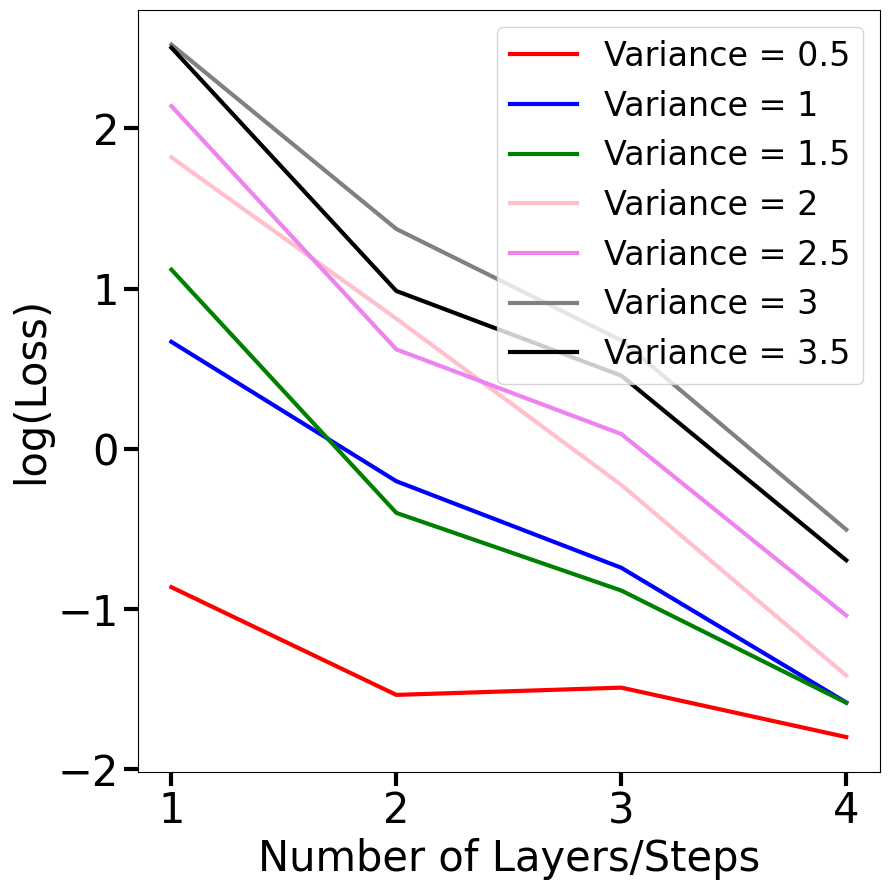

In [36]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (9, 9))

losses05 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict05.keys()
for idx, key in enumerate(keys):
    losses05[idx,:] = loss_dict05[key]
losses_mean05 = torch.mean(losses05, axis=0)
losses_std05 = torch.std(losses05, axis=0)/10

ax.plot(n_layers, losses_mean05, color = 'red', lw = 3, label='Variance = 0.5')
#ax.fill_between(n_layers, losses_mean1-losses_std1, losses_mean1+losses_std1, color = 'red', alpha = 0.2)

losses1 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict1.keys()
for idx, key in enumerate(keys):
    losses1[idx,:] = loss_dict1[key]
losses_mean1 = torch.mean(losses1, axis=0)
losses_std1 = torch.std(losses1, axis=0)/10

ax.plot(n_layers, losses_mean1, color = 'blue', lw = 3, label='Variance = 1')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

losses15 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict15.keys()
for idx, key in enumerate(keys):
    losses15[idx,:] = loss_dict15[key]
losses_mean15 = torch.mean(losses15, axis=0)
losses_std15 = torch.std(losses15, axis=0)/10

ax.plot(n_layers, losses_mean15, color = 'green', lw = 3, label='Variance = 1.5')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

losses2 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict2.keys()
for idx, key in enumerate(keys):
    losses2[idx,:] = loss_dict2[key]
losses_mean2 = torch.mean(losses2, axis=0)
losses_std2 = torch.std(losses2, axis=0)/10

ax.plot(n_layers, losses_mean2, color = 'pink', lw = 3, label='Variance = 2')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

losses25 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict25.keys()
for idx, key in enumerate(keys):
    losses25[idx,:] = loss_dict25[key]
losses_mean25 = torch.mean(losses25, axis=0)
losses_std25 = torch.std(losses25, axis=0)/10

ax.plot(n_layers, losses_mean25, color = 'violet', lw = 3, label='Variance = 2.5')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

losses3 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict3.keys()
for idx, key in enumerate(keys):
    losses3[idx,:] = loss_dict3[key]
losses_mean3 = torch.mean(losses3, axis=0)
losses_std3 = torch.std(losses3, axis=0)/10

ax.plot(n_layers, losses_mean3, color = 'grey', lw = 3, label='Variance = 3')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

losses35 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict35.keys()
for idx, key in enumerate(keys):
    losses35[idx,:] = loss_dict35[key]
losses_mean35 = torch.mean(losses35, axis=0)
losses_std35 = torch.std(losses35, axis=0)/10

ax.plot(n_layers, losses_mean35, color = 'black', lw = 3, label='Variance = 3.5')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

plt.ylabel('log(Loss)',fontsize=30)
plt.xlabel('Number of Layers/Steps',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
ax.legend(fontsize=24)
#ax.set_yscale('log')

plt.tight_layout()
plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)

<ipython-input-38-33abe11bc5bf>:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std05 = torch.std(losses05, axis=0) / 10
<ipython-input-38-33abe11bc5bf>:33: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std1 = torch.std(losses1, axis=0) / 10
<ipython-input-38-33abe11bc5bf>:50: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std15 = torch.std(losses15, axis=0) / 10
<ipython-input-38-33abe11bc5bf>:66: UserWarning: std(): degrees of freedom is <= 0. Correc

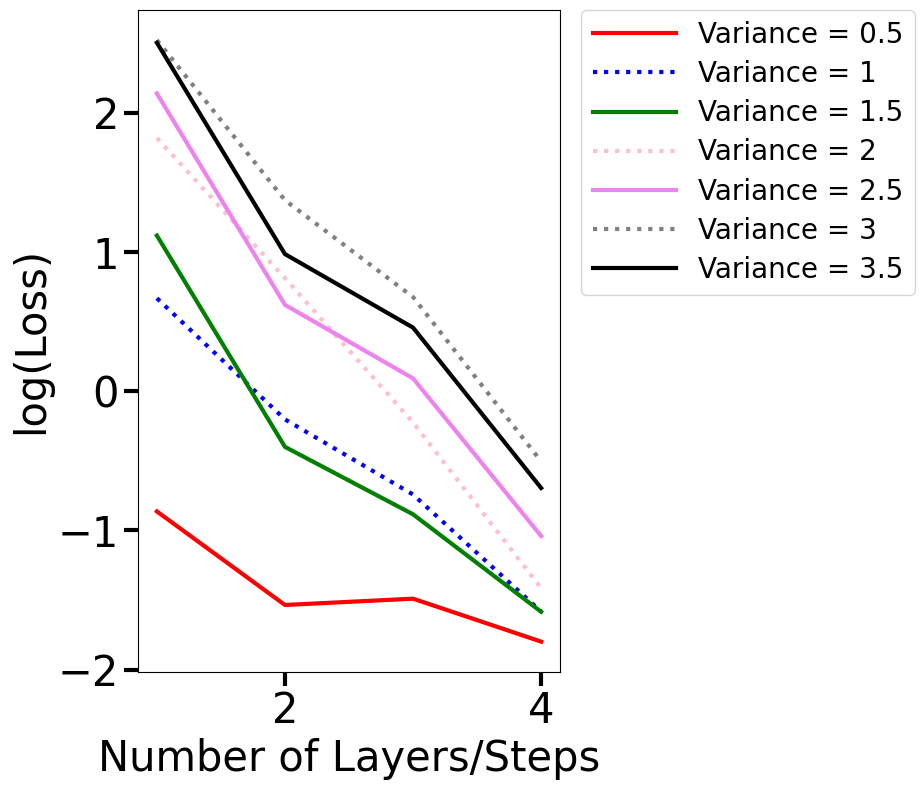

In [38]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

# Increase the width of the figure (e.g., 12 inches wide, 8 inches tall)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot for variance = 0.5
losses05 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict05.keys()
for idx, key in enumerate(keys):
    losses05[idx, :] = loss_dict05[key]
losses_mean05 = torch.mean(losses05, axis=0)
losses_std05 = torch.std(losses05, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean05,
    color='red',
    lw=3,
    label='Variance = 0.5'
)

# Plot for variance = 1 (make dotted)
losses1 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict1.keys()
for idx, key in enumerate(keys):
    losses1[idx, :] = loss_dict1[key]
losses_mean1 = torch.mean(losses1, axis=0)
losses_std1 = torch.std(losses1, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean1,
    color='blue',
    lw=3,
    linestyle=':',  # dotted line
    label='Variance = 1'
)

# Plot for variance = 1.5
losses15 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict15.keys()
for idx, key in enumerate(keys):
    losses15[idx, :] = loss_dict15[key]
losses_mean15 = torch.mean(losses15, axis=0)
losses_std15 = torch.std(losses15, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean15,
    color='green',
    lw=3,
    label='Variance = 1.5'
)

# Plot for variance = 2 (make dotted)
losses2 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict2.keys()
for idx, key in enumerate(keys):
    losses2[idx, :] = loss_dict2[key]
losses_mean2 = torch.mean(losses2, axis=0)
losses_std2 = torch.std(losses2, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean2,
    color='pink',
    lw=3,
    linestyle=':',  # dotted line
    label='Variance = 2'
)

# Plot for variance = 2.5
losses25 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict25.keys()
for idx, key in enumerate(keys):
    losses25[idx, :] = loss_dict25[key]
losses_mean25 = torch.mean(losses25, axis=0)
losses_std25 = torch.std(losses25, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean25,
    color='violet',
    lw=3,
    label='Variance = 2.5'
)

# Plot for variance = 3 (make dotted)
losses3 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict3.keys()
for idx, key in enumerate(keys):
    losses3[idx, :] = loss_dict3[key]
losses_mean3 = torch.mean(losses3, axis=0)
losses_std3 = torch.std(losses3, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean3,
    color='grey',
    lw=3,
    linestyle=':',  # dotted line
    label='Variance = 3'
)

# Plot for variance = 3.5
losses35 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict35.keys()
for idx, key in enumerate(keys):
    losses35[idx, :] = loss_dict35[key]
losses_mean35 = torch.mean(losses35, axis=0)
losses_std35 = torch.std(losses35, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean35,
    color='black',
    lw=3,
    label='Variance = 3.5'
)

plt.ylabel('log(Loss)', fontsize=30)
plt.xlabel('Number of Layers/Steps', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width=3, length=10)
ax.tick_params(axis='both', which='minor', labelsize=20, width=3, length=5)

# Adjust legend properties to make it smaller and place it outside
ax.legend(
    fontsize=20,            # smaller font size for the legend
    loc='upper left',
    bbox_to_anchor=(1.05, 1.0),
    borderaxespad=0.,
    labelspacing=0.4,       # adjust space between legend entries
    handlelength=3          # length of the legend lines
)

# Use 'rect' in tight_layout to leave space on the right for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])  # 0.8 leaves some room on the right

plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)

In [62]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [2.5, 0.0, -1.0]      # E.g., 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [0.5, 1.0, 2.0]   # per-component variance
weights = [0.2, 0.3, 0.5]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 3

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1       # if your original code uses gamma distributions, etc.
mode = 'normal'     # we'll just use "normal" mode in generate_data
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # just an example of different layer depths

# Prepare logging
loss_dict_gmm = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            # We'll pass data_mean=means[head_idx], data_variance=variances[head_idx]
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U = None, D = None, data_variance=variances[head_idx], data_mean=means[head_idx])        # <--- non-zero mean for this component
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head's parameters => head_model.allparam
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components),
        # whose overall mean is zero by design.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # Fine-tune gating only
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 5000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict001" will contain
# the logged test losses for each seed and layer configuration.

In [63]:
loss_dict_gmm

{(0,): tensor([ 0.48, -0.38, -0.78, -1.03])}

In [52]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [2.5]      # E.g., 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [0.5]   # per-component variance
weights = [1]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 1

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1       # if your original code uses gamma distributions, etc.
mode = 'normal'     # we'll just use "normal" mode in generate_data
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # just an example of different layer depths

# Prepare logging
loss_dict_gmm1 = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm1[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            # We'll pass data_mean=means[head_idx], data_variance=variances[head_idx]
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U = None, D = None, data_variance=variances[head_idx], data_mean=means[head_idx])        # <--- non-zero mean for this component
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head's parameters => head_model.allparam
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components),
        # whose overall mean is zero by design.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # Fine-tune gating only
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 2000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm1[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict001" will contain
# the logged test losses for each seed and layer configuration.

In [54]:
loss_dict_gmm1

{(0,): tensor([-0.47, -0.66, -0.65, -0.57])}

In [55]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [0]      # E.g., 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [1]   # per-component variance
weights = [1]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 1

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1       # if your original code uses gamma distributions, etc.
mode = 'normal'     # we'll just use "normal" mode in generate_data
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # just an example of different layer depths

# Prepare logging
loss_dict_gmm2 = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm2[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            # We'll pass data_mean=means[head_idx], data_variance=variances[head_idx]
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U = None, D = None, data_variance=variances[head_idx], data_mean=means[head_idx])        # <--- non-zero mean for this component
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head's parameters => head_model.allparam
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components),
        # whose overall mean is zero by design.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # Fine-tune gating only
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 2000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm2[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict001" will contain
# the logged test losses for each seed and layer configuration.

In [56]:
loss_dict_gmm2

{(0,): tensor([-1.21, -1.95, -2.33, -2.83])}

In [57]:
########################################################
# Modified Training/Testing Code for a 3-Component GMM
# Each head is trained on a single component (non-zero mean),
# but the overall mixture has mean 0.
########################################################

import torch
import numpy as np

# Suppose these are the means, variances, and weights for 3 components
# whose *weighted* mean is zero:
means = [-1]      # E.g., 0.2*2.5 + 0.3*0.0 + 0.5*(-1.0) = 0
variances = [2]   # per-component variance
weights = [1]     # must sum to 1

# We'll have 3 heads, one per component
n_head = 1

# Example hyperparameters
lr = 1e-3
B = 1000            # total batch size
epochs = 300
shape_k = 0.1       # if your original code uses gamma distributions, etc.
mode = 'normal'     # we'll just use "normal" mode in generate_data
N = 20
d = 1
var = 0.01          # variance for Transformer_F parameter init
n_layers = [1, 2, 3, 4]   # just an example of different layer depths

# Prepare logging
loss_dict_gmm3 = {}
seeds = [0]

for sd in seeds:
    key = (sd,)
    loss_dict_gmm3[key] = torch.zeros(len(n_layers))

    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []

        for head_idx in range(n_head):
            # Create a fresh single-head model (run_mode=0, head_choice=head_idx)
            head_model = Transformer_F(
                n_layer=n_layer,
                n_head=n_head,
                N=N,
                d=d,
                var=var,
                run_mode=0,
                head_choice=head_idx
            ).to(device)
            head_model.train()

            # Generate training data for THIS head => single Gaussian component
            # We'll pass data_mean=means[head_idx], data_variance=variances[head_idx]
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U = None, D = None, data_variance=variances[head_idx], data_mean=means[head_idx])        # <--- non-zero mean for this component
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head's parameters => head_model.allparam
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)

            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store the trained parameters for this head
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into one model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Overwrite each head's portion of allparam with the trained values
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = \
                    head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on GMM test data
        # We'll sample B points from the entire mixture (all 3 components),
        # whose overall mean is zero by design.
        # ----------------------------------------------

        # "comp_indices" = which component each sample belongs to
        comp_indices = np.random.choice(range(n_head), size=B, p=weights)

        # We'll accumulate the mixture data in lists, then cat them
        Z_list = []
        y_list = []
        for i in range(n_head):
            # How many from component i?
            mask = (comp_indices == i)
            num_i = mask.sum()
            if num_i == 0:
                continue

            # Generate data_mean=means[i], data_variance=variances[i],
            # but only for "num_i" samples
            Z_temp, y_temp = generate_data(
                mode=mode,
                N=N,
                d=d,
                B=num_i,               # <--- generate exactly num_i points
                shape_k=shape_k,
                U=None,
                D=None,
                data_variance=variances[i],
                data_mean=means[i]
            )
            Z_list.append(Z_temp)
            y_list.append(y_temp)

        # Combine test data from all components => full GMM sample
        Z_test = torch.cat(Z_list, dim=0).to(device)
        y_test = torch.cat(y_list, dim=0).to(device)

        # Fine-tune gating only
        model.gate.requires_grad = True
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)
        fine_tune_iters = 2000
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict_gmm3[key][idx] = final_loss.log().item()

# After this loop completes, "loss_dict001" will contain
# the logged test losses for each seed and layer configuration.

In [58]:
loss_dict_gmm3

{(0,): tensor([-0.11, -1.03, -1.02, -1.18])}

<ipython-input-66-7440fdc9539b>:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std_gmm = torch.std(losses_gmm, axis=0) / 10
<ipython-input-66-7440fdc9539b>:33: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std_gmm1 = torch.std(losses_gmm1, axis=0) / 10
<ipython-input-66-7440fdc9539b>:50: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std_gmm2 = torch.std(losses_gmm2, axis=0) / 10
<ipython-input-66-7440fdc9539b>:67: UserWarning: std(): degrees of freed

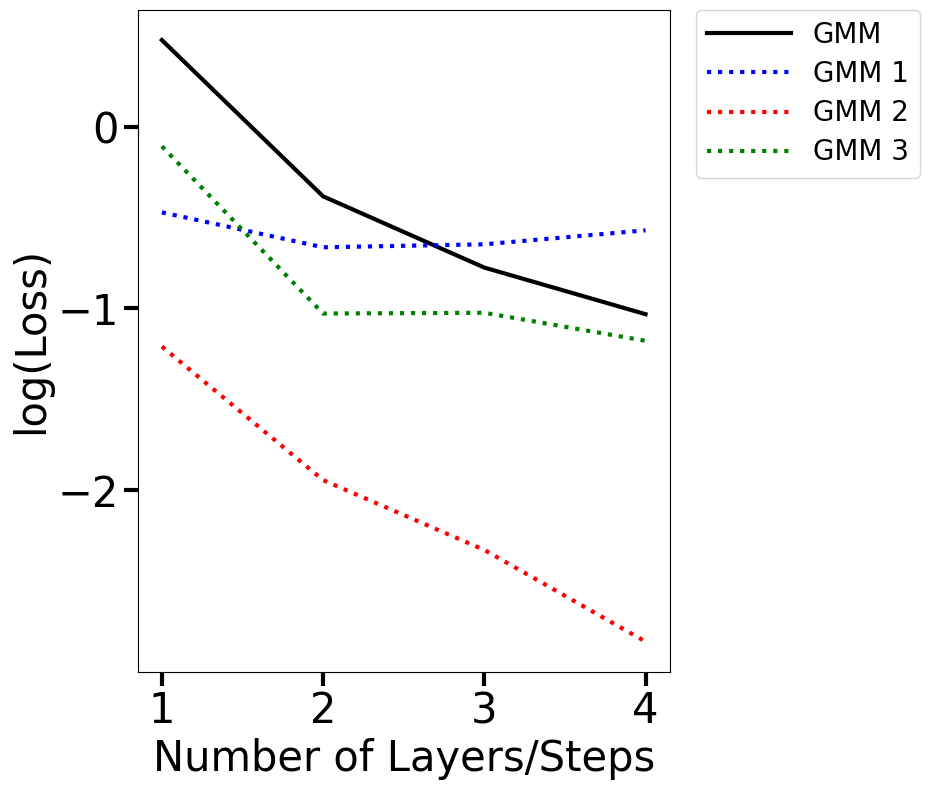

In [66]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

# Increase the width of the figure (e.g., 12 inches wide, 8 inches tall)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot for GMM
losses_gmm = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_gmm.keys()
for idx, key in enumerate(keys):
    losses_gmm[idx, :] = loss_dict_gmm[key]
losses_mean_gmm = torch.mean(losses_gmm, axis=0)
losses_std_gmm = torch.std(losses_gmm, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean_gmm,
    color='black',
    lw=3,
    label='GMM'
)

# Plot for GMM 1
losses_gmm1 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_gmm1.keys()
for idx, key in enumerate(keys):
    losses_gmm1[idx, :] = loss_dict_gmm1[key]
losses_mean_gmm1 = torch.mean(losses_gmm1, axis=0)
losses_std_gmm1 = torch.std(losses_gmm1, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean_gmm1,
    color='blue',
    lw=3,
    linestyle=':',  # dotted line
    label='GMM 1'
)

# Plot for GMM 2
losses_gmm2 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_gmm2.keys()
for idx, key in enumerate(keys):
    losses_gmm2[idx, :] = loss_dict_gmm2[key]
losses_mean_gmm2 = torch.mean(losses_gmm2, axis=0)
losses_std_gmm2 = torch.std(losses_gmm2, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean_gmm2,
    color='red',
    lw=3,
    linestyle=':',  # dotted line
    label='GMM 2'
)

# Plot for GMM 3
losses_gmm3 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_gmm3.keys()
for idx, key in enumerate(keys):
    losses_gmm3[idx, :] = loss_dict_gmm3[key]
losses_mean_gmm3 = torch.mean(losses_gmm3, axis=0)
losses_std_gmm3 = torch.std(losses_gmm3, axis=0) / 10

ax.plot(
    n_layers,
    losses_mean_gmm3,
    color='green',
    lw=3,
    linestyle=':',  # dotted line
    label='GMM 3'
)

plt.ylabel('log(Loss)', fontsize=30)
plt.xlabel('Number of Layers/Steps', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width=3, length=10)
ax.tick_params(axis='both', which='minor', labelsize=20, width=3, length=5)

# Adjust legend properties to make it smaller and place it outside
ax.legend(
    fontsize=20,            # smaller font size for the legend
    loc='upper left',
    bbox_to_anchor=(1.05, 1.0),
    borderaxespad=0.,
    labelspacing=0.4,       # adjust space between legend entries
    handlelength=3          # length of the legend lines
)

# Use 'rect' in tight_layout to leave space on the right for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])  # 0.8 leaves some room on the right

plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)